In [1]:
import numpy as np
import matplotlib.pyplot as plt
import functools
from platypus.algorithms import NSGAII
from platypus.core import Problem
from platypus.types import Real

In [2]:

# Set some parameters
K = 975  # capacity, TAF
D = 150  # target yield, TAF
a = 0.35
b = 2.3  # cost function parameters

# data setup
historical_flow = np.loadtxt('FOL-monthly-inflow-TAF.csv', delimiter=',', skiprows=1, usecols=[1])
T = len(historical_flow)

dry_flow = historical_flow * .8
wet_flow = historical_flow * 1.2

mean_flow = np.mean(historical_flow)
std_flow = np.std(historical_flow)
s_t = ((historical_flow - mean_flow) / std_flow)
s_t_prime = 1.2 * s_t
variable_flow_neg = s_t_prime * std_flow + mean_flow
variable_flow = np.where(variable_flow_neg < 0, 0, variable_flow_neg)

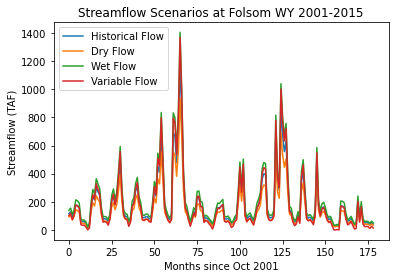

In [3]:
plt.plot(historical_flow, label='Historical Flow')
plt.plot(dry_flow, label='Dry Flow')
plt.plot(wet_flow, label='Wet Flow')
plt.plot(variable_flow, label='Variable Flow')
plt.xlabel("Months since Oct 2001")
plt.ylabel("Streamflow (TAF)")
plt.title("Streamflow Scenarios at Folsom WY 2001-2015")
plt.legend()
plt.show()

In [4]:
# same function, but now returns 2 objectives

def simulate(x, streamflow):
    S = np.zeros(T)
    R = np.zeros(T)
    cost = np.zeros(T)
    h0 = x[0]
    hf = x[1]
    Q = streamflow

    S[0] = K  # start simulation full
    reliability = 0

    for t in range(1, T):

        # new storage: mass balance, max value is K
        S[t] = min(S[t - 1] + Q[t - 1] - R[t - 1], K)

        # determine R from hedging policy
        W = S[t] + Q[t]
        if W > hf:
            R[t] = D
            reliability += 1.0 / T
        elif W < h0:
            R[t] = W
        else:
            R[t] = (D - h0) / (hf - h0) * (W - h0) + h0
        #
        shortage = D - R[t]
        cost[t] = a * shortage ** b
        #  Quadratic
    return [cost.mean(), reliability]

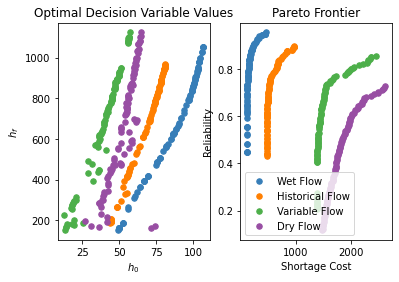

In [5]:
flows = [wet_flow, historical_flow, variable_flow, dry_flow]
# color blind friendly cycle: https://gist.github.com/thriveth/8560036
colors = ['#377eb8', '#ff7f00', '#4daf4a',
          '#984ea3']

for k in range(len(flows)):
    # Problem(number of decisions, number of objectives)
    problem = Problem(2, 2)
    problem.types[0] = Real(0, D)
    problem.types[1] = Real(D, K + D)
    problem.directions[1] = Problem.MAXIMIZE
    # dont need minimize for index 0 bc that is default
    problem.function = functools.partial(simulate, streamflow=flows[k])

    algorithm = NSGAII(problem)

    # optimize the problem using 10000 function evaluations
    algorithm.run(10000)

    # just plotting below here ~~~~~~~~~~~~~
    # convert data to numpy first..
    obj = np.array([s.objectives for s in algorithm.result])
    x = np.array([s.variables for s in algorithm.result])

    # to make a contour plot...
    h0s = np.arange(0, D, 5)
    hfs = np.arange(D, K + D, 5)
    X, Y = np.meshgrid(h0s, hfs)
    costs = np.zeros((len(h0s), len(hfs)))
    rels = np.zeros((len(h0s), len(hfs)))
    i, j = 0, 0

    # fill in matrices for contour plot
    for i, h0 in enumerate(h0s):
        for j, hf in enumerate(hfs):
            costs[i, j], rels[i, j] = simulate([h0, hf], streamflow=flows[k])

    plt.subplot(1, 2, 1)
    # plt.contour(X,Y,costs.T, 50, cmap=plt.cm.cool)
    # plt.contour(X,Y,rels.T, 50, cmap=plt.cm.Reds)
    plt.scatter(x[:, 0], x[:, 1], s=30, color=colors[k], zorder=5)
    plt.xlabel(r'$h_0$')
    plt.ylabel(r'$h_f$')
    plt.title('Optimal Decision Variable Values')

    plt.subplot(1, 2, 2)
    plt.scatter(obj[:, 0], obj[:, 1], s=30, color=colors[k])
    plt.xlabel('Shortage Cost')
    plt.ylabel('Reliability')
    plt.title('Pareto Frontier')

plt.legend(['Wet Flow', 'Historical Flow', 'Variable Flow', 'Dry Flow'])
plt.show()

In [6]:
h0 = 63.6
hf = 564.4

print(simulate([h0, hf], wet_flow))

print(simulate([h0, hf], historical_flow))

print(simulate([h0, hf], variable_flow))

print(simulate([h0, hf], dry_flow))

[230.93516419942029, 0.860335195530729]
[565.6088827505301, 0.765363128491622]
[1594.8359693688271, 0.703910614525141]
[1878.9979308786858, 0.508379888268156]


In [7]:
dry_mean_flow = np.mean(dry_flow)
dry_std_flow = np.std(dry_flow)

var_mean_flow = np.mean(variable_flow)
var_std_flow = np.std(variable_flow)

print(dry_mean_flow, dry_std_flow)
print(var_mean_flow, var_std_flow)

147.33198294594638 144.65700183326865
184.3278258111339 216.8423895393001
